# Exercise 1

### Exercise 1.1

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import scipy as sp
import matplotlib.pyplot as plt
import collections 
from tqdm import tqdm 
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this part you will simulate an epidemic on a symmetric k-regular undirected graph with
node set V = {1, . . . , n} where every node is directly connected to the k = 4 nodes whose
index is closest to their own modulo n.

The disease propagation model that you will use to simulate the epidemic is a discrete-time
simplified version of the SIR epidemic model

The epidemic is driven by the following transition probabilities:
$$
    P(X_i(t+1) = I | X_i(t) = S, \sum_{j \in \mathbf(V)}{W_{ij}\delta^I_{X_j(t) = m}}) = 1 - (1 - \beta)^m
$$

$$
    P(X_i(t+1) = R | X_i(t) = I ) = \rho
$$

In [9]:
# draw the k regular graph 

n_nodes = 500
k = 4
# since k = 4, we need to create 2 upper diagonals and 2 lower diagonals 
# create the upper diagonals
diag1 = np.diag(np.ones(n_nodes - 1), k = 1)
diag_1 = np.diag(np.ones(n_nodes - 1), k = -1)

# create the lower diagonals
diag2 = np.diag(np.ones(n_nodes - 2), k = 2)
diag_2 = np.diag(np.ones(n_nodes - 2), k = -2)

# merge the diagonals together 
W = np.array(diag1 + diag_1 + diag2 + diag_2)

# remember to add those edges that ends the connection -> in total we need to have 4*n_nodes links 
W[0,-2:] = 1
W[1,-1] = 1

W[-2,0] = 1
W[-1,:2] = 1


In [10]:
# Required elements to run the simulation: 
n_agents = n_nodes
n_steps = 16 # number of weeeks
beta = 0.3   # parameter used to compute infected prob
rho = 0.7    # recover prob

# obtain the graph to facilitate some computations
G = nx.from_numpy_matrix(W)
# nx.draw_spectral(G, with_labels=True)
# plt.savefig('10nodespic.png')



In [11]:
W = sp.sparse.lil_matrix(W)

more efficient simulation method is proposed below, which may turn useful if you need to deal with larger networks or more complicated models (e.g., SIR dynamics, in which the number of states is $3^{n}$). Instead of precomputing the transition matrix $\Lambda$, it computes its rows along the way when needed. In particular, when the process is at some configuration $x$, row $x$ of $\Lambda$ is computed, used to compute the probabilities of transitions from $x$ and to pick the next visited configuration.


In [12]:
simulation = 100

# initialize the state array which is used to store the state of each agent in the weeks for every simulation
states = np.zeros((simulation,n_steps,n_agents), dtype=np.int64)

# initialize the required arrays in order to save the statistics
newly_infected = np.zeros((simulation,n_steps), dtype = np.int64)
tot_susceptible = np.zeros((simulation,n_steps), dtype = np.int64)
tot_infected = np.zeros((simulation,n_steps), dtype = np.int64)
tot_recovered = np.zeros((simulation,n_steps), dtype = np.int64)

# for each simulation
for sim in tqdm(range(simulation)):
    # in the initial configuration, 10 random nodes are chosen to be infected
    x0 = np.zeros(n_agents, dtype=int)
    array = np.random.choice(n_agents, 10 , replace=False)
    newly_infected[sim][0] = 10
    x0[array]=1

    # define initial state (week 0)
    states[sim][0] = x0

    # update the number of the statistics
    tot_susceptible[sim][0] = np.count_nonzero(states[sim][0] == 0)
    tot_infected[sim][0] = np.count_nonzero(states[sim][0] == 1)
    tot_recovered[sim][0] = np.count_nonzero(states[sim][0] == 2)

    # for each week of the simulation
    for i in range(1,n_steps):
        # consider the current configuration
        x = np.array(states[sim][i-1])

        # construct y as the next possible configuration based on the previous state
        y = np.array(states[sim][i-1])

        for agent in range(n_agents):  
            if x[agent] == 0: # the node is susceptible
                infected_neighbor = 0
                
                for neighbor in [n for n in G.neighbors(agent)]:
                    # if the other agent is infected, x[other_agent] = 1
                    if x[neighbor] == 1:
                        # increase the neighbor
                        infected_neighbor += 1
                        
                rate = 1 - pow((1 - beta),infected_neighbor)
                prob = [rate, 1-rate] # we will associate the probs as follows : 
                                      # 1-rate = not infect, rate = infect
                    
                infection = np.random.choice([True, False] ,1, p = prob)[0]
                if infection == True:
                    y[agent] = 1 # the agent become infected in the next config
                    newly_infected[sim][i] += 1 

            if x[agent] == 1: # the node is infected
                rate = rho
                prob = [rate, 1-rate] 
                recover = np.random.choice([True,False], 1, p = prob)[0]
                if recover == True:
                    y[agent] = 2 # the agent become recovered in the next config

        # update the state 
        states[sim][i] = y
        
        # update the statistics
        tot_susceptible[sim][i] = np.count_nonzero(states[sim][i] == 0)
        tot_infected[sim][i] = np.count_nonzero(states[sim][i] == 1)
        tot_recovered[sim][i] = np.count_nonzero(states[sim][i] == 2)
        


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.86it/s]


[10.   12.64 11.54  8.78  6.34  4.44  3.18  2.23  1.62  1.19  0.91  0.77
  0.46  0.28  0.21  0.16]


Text(0, 0.5, 'new infected')

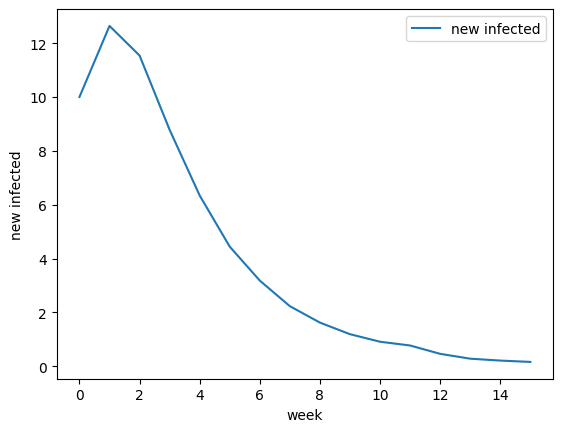

In [13]:
#plot the graph for new_infected

time = np.arange(n_steps)

avg_newinfect = np.mean(newly_infected,axis = 0)
print(avg_newinfect)

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'new infected')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')

# plt.savefig('plot1.1new_infected.png')

Text(0, 0.5, 'n_agents')

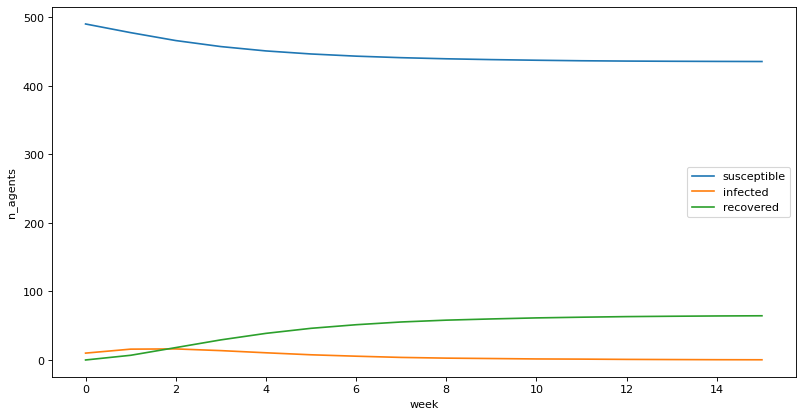

In [14]:
#plot the graph for tot susceptible, infected and recovered in each week

time = np.arange(n_steps)
avg_sus = np.mean(tot_susceptible,axis = 0)
avg_inf = np.mean(tot_infected,axis = 0)
avg_rec = np.mean(tot_recovered,axis = 0)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')

# plt.savefig('plot1.1stats.png')

### Exercise 1.2


In this part you will generate a random graph according to the preferential attachment model.
The goal is to have a randomly generated graph with average degree close to k.

In [8]:
k = 4

odd = False
if k%2 == 1:
    odd = True

# Preferential attachment
GPA =  nx.complete_graph(k+1)

n_nodes = 900

# add the remaining nodes one at a time
for new_node in range(k+1,n_nodes):
    # the min guarantees that the new node is not assigned a degree
    # larger than the current size of the preferential attachment graph
    if odd == True:
        if new_node%2 == 1:
            degree = int(np.floor(k/2))
        else:
            degree = int(np.ceil(k/2))
    else:
        degree = int(k/2)
        
    # choose `degree` neighbors for node to connect to according to their 
    # degree in the current approximation GPA.
    deg_PA = [d for n, d in GPA.degree()] 
    
    deg_PA = np.array(deg_PA, dtype = np.int64)
    # normalize to obtain a probability distribution
    
    deg_PA = deg_PA/sum(deg_PA)
    # replace=False guarantees no neighbor is chosen twice
    neighbors = np.random.choice(np.arange(len(GPA)), degree, p=deg_PA , replace=False)
        
    # add the new node 
    GPA.add_node(new_node)
    # add the new links 
    for neigh in neighbors:
        GPA.add_edge(new_node,neigh) 

# extract the degrees of each node to check the average degree
degrees = np.zeros(n_nodes)
for n, d in GPA.degree:
    degrees[n] = d
np.mean(degrees)

4.0

In [10]:
np.min(degrees)

2.0

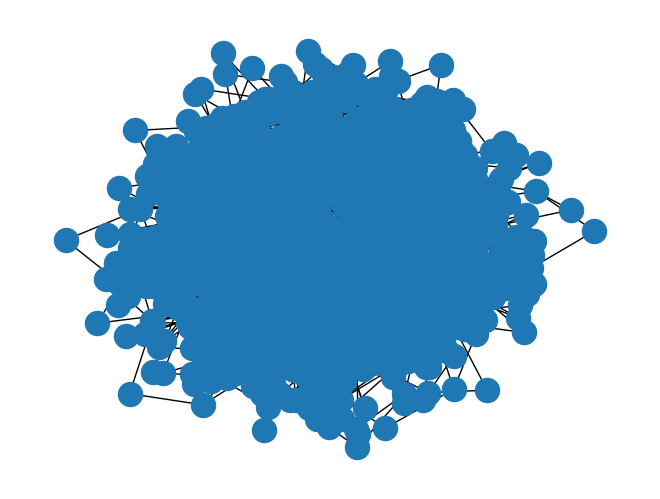

In [11]:
nx.draw(GPA)

### Exercise 2

Using the methods developed in Section 1.1, generate a preferential attachment random graph G = (V, E), with |V| = 500 nodes. the average degree should be 6

In [2]:
def randomgraph(k, n_nodes):
    
    # check if k is odd or even -> we have different update method
    odd = False
    if k%2 == 1:
        odd = True

    # starting the Preferential attachment
    GPA =  nx.complete_graph(k+1)

    # add the remaining nodes one at a time
    for new_node in range(k+1,n_nodes):
        
        if odd == True: # if k is odd -> dividing it by 2 we have float value
                        # we need to use a strategy where we alternate the number
                        # of added edges for each node, in order to keep the 
                        # average degree equal to the desired value 
            
            # alternation -> one time we take the floor value, one time we take the ceil value           
            if new_node%2 == 1:
                degree = int(np.floor(k/2))
            else:
                degree = int(np.ceil(k/2))
        else:
            degree = int(k/2)
        # choose `degree` neighbors for node to connect to according to their 
        # degree in the current approximation GPA.
        deg_PA = [d for n, d in GPA.degree()] 
        
        deg_PA = np.array(deg_PA, dtype = np.int64)
        # normalize to obtain a probability distribution
        deg_PA = deg_PA/sum(deg_PA)
        
        # replace=False guarantees no neighbor is chosen twice
        neighbors = np.random.choice(np.arange(len(GPA)), degree, p=deg_PA , replace=False)

        # add the new node
        GPA.add_node(new_node)
        # add the new links 
        for neigh in neighbors:
            GPA.add_edge(new_node,neigh) 

    degrees = np.zeros(n_nodes)
    for n, d in GPA.degree:
        degrees[n] = d
    
    return GPA

In [15]:
def SIRsimulation(simulation, n_steps, n_agents, W, beta, rho):

    # state saves the state of the agents for each week in each simulation
    states = np.zeros((simulation,n_steps,n_agents), dtype=np.int64)
    
    # stats used to plot the graphs
    newly_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_susceptible = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_recovered = np.zeros((simulation,n_steps), dtype = np.int64)

    for sim in tqdm(range(simulation)):
        # in the initial configuration, 10 random nodes are infected
        x0 = np.zeros(n_agents, dtype=int)
        array = np.random.choice(n_agents, 10 , replace=False)
        x0[array]=1
    
        # define initial state id (time 0)
        states[sim][0] = x0
        
        # update the stats
        newly_infected[sim][0] = 10
        tot_susceptible[sim][0] = np.count_nonzero(states[sim][0] == 0)
        tot_infected[sim][0] = np.count_nonzero(states[sim][0] == 1)
        tot_recovered[sim][0] = np.count_nonzero(states[sim][0] == 2)

        # for each step of the simulation
        for i in range(1,n_steps):
            # consider the current configuration
            x = np.array(states[sim][i-1])

            # construct y as the next possible configuration based on the previous state
            y = np.array(states[sim][i-1])

            for agent in range(n_agents):  
                if x[agent] == 0: # the node is susceptible
                    infected_neighbor = 0

                    for neighbor in [n for n in G.neighbors(agent)]:
                        # if the other agent is infected, x[other_agent] = 1
                        if x[neighbor] == 1:
                            infected_neighbor += 1
                    
                    rate = 1 - pow((1 - beta),infected_neighbor)
                    prob = [rate, 1-rate] # we will associate the probs as follows : 
                                          # rate = infect, 1-rate =not infect 
                        
                    infection = np.random.choice([True, False] ,1, p = prob)[0]
                    if infection == True:
                        y[agent] = 1 # the agent become infected in the next config
                        newly_infected[sim][i] += 1

                if x[agent] == 1: # the node is infected
                    rate = rho
                    prob = [rate, 1-rate] 
                    recover = np.random.choice([True,False], 1, p = prob)[0]
                    if recover == True:
                        y[agent] = 2 # the agent become recovered in the next config

            # update the state
            states[sim][i] = y
            
            # update the stats
            tot_susceptible[sim][i] = np.count_nonzero(states[sim][i] == 0)
            tot_infected[sim][i] = np.count_nonzero(states[sim][i] == 1)
            tot_recovered[sim][i] = np.count_nonzero(states[sim][i] == 2)


    return newly_infected, tot_susceptible, tot_infected, tot_recovered


In [16]:
simulation = 100
n_steps = 16
n_nodes = 500
k = 6
beta = 0.3
rho = 0.7

# create the random graph with preferential attachment property
G = randomgraph(k, n_nodes)
W = nx.adjacency_matrix(G)
W = sp.sparse.lil_matrix(W)

# start the simulation
newly_infected, tot_susceptible, tot_infected, tot_recovered = SIRsimulation(simulation, n_steps, n_nodes, W, beta, rho)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


[1.0000e+01 1.7660e+01 5.1100e+01 9.4960e+01 1.0334e+02 6.9510e+01
 3.5220e+01 1.6120e+01 7.3400e+00 2.5100e+00 1.1000e+00 4.9000e-01
 2.7000e-01 1.5000e-01 6.0000e-02 7.0000e-02]


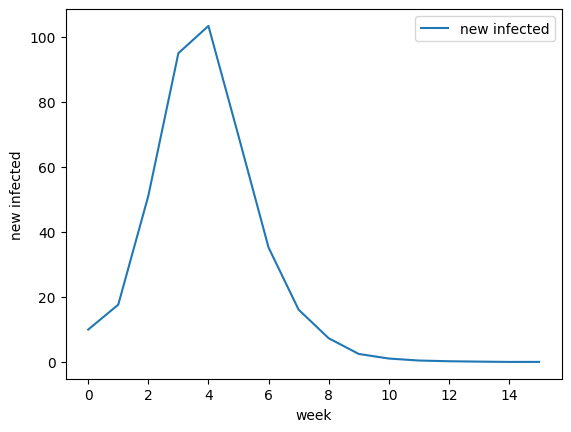

In [17]:
#plot the graph for newly infected for each week

time = np.arange(n_steps)

avg_newinfect = np.mean(newly_infected,axis = 0)
print(avg_newinfect)

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'new infected')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')

plt.savefig('plot2new_infected')

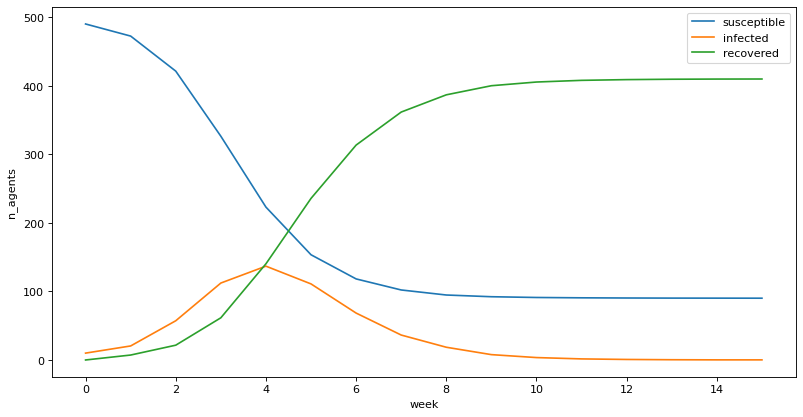

In [18]:
# graph for tot susceptible, infected and recovered each week
time = np.arange(n_steps)
avg_sus = np.mean(tot_susceptible,axis = 0)
avg_inf = np.mean(tot_infected,axis = 0)
avg_rec = np.mean(tot_recovered,axis = 0)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')

plt.savefig('plot2stats')

### Exercise 3


In [19]:
def SIRsimulationwithvaccine(simulation, n_steps, n_agents, W, beta, rho, vaccine):

    # we add the vaccine in this case
    vaccine = np.array(vaccine)
    # state saves the state of the agents for each week in each simulation
    states = np.zeros((simulation,n_steps,n_agents), dtype=np.int64)
    
    # stats
    newly_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    newly_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_susceptible = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_recovered = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)

    for sim in tqdm(range(simulation)):
        
        # initial state
        x0 = np.zeros(n_agents, dtype=int)
        # initialize vaccinated people
        vaccine_size = round(vaccine[0]*n_agents/100)
        # find all the not vaccinated people 
        node_notvaccinated = np.where(states[sim][0] != 4)
        # random choice over the not vaccinated people
        new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False) 
        # update their state
        x0[new_vaccinated] = 4
        
        # in the initial configuration, 10 random nodes are infected, despite those one already vaccinated
        # we infect 10 people among those one who didn't receive a vaccine 
        node_notvaccinated = np.where(x0 != 4)
        array = np.random.choice(node_notvaccinated[0] ,10 , replace=False)
        # set their state to 1
        x0[array]=1
        
        # update stats 
        newly_vaccinated[sim][0] = len(new_vaccinated)
        newly_infected[sim][0] = 10
        
        # define initial state id (time 0)
        states[sim][0] = x0

        # update stats
        tot_susceptible[sim][0] = np.count_nonzero(states[sim][0] == 0)
        tot_infected[sim][0] = np.count_nonzero(states[sim][0] == 1)
        tot_recovered[sim][0] = np.count_nonzero(states[sim][0] == 2)
        tot_vaccinated[sim][0] = np.count_nonzero(states[sim][0] == 4)

        # for each step of the simulation
        for i in range(1,n_steps):
            
            # consider the current configuration 
            x = np.array(states[sim][i-1])
            
            # vaccination of the population
            vaccine_size = round((vaccine[i]-vaccine[i-1])*n_agents/100)
            # find those people who are not vaccinated -> we need to choose among those who
            # haven't received a vaccine yet
            node_notvaccinated = np.where(states[sim][i-1] != 4)
            new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False)    
            # update their status
            x[new_vaccinated] = 4
            
            # stats
            newly_vaccinated[sim][i] = len(new_vaccinated)

            # construct y as the next possible configuration based on the previous state,
            # already considering those who took the vaccine
            y = np.array(x)

            for agent in range(n_agents):  
                if x[agent] == 0: # the node is susceptible
                    infected_neighbor = 0

                    for neighbor in [n for n in G.neighbors(agent)]:
                        # if the other agent is infected, x[other_agent] = 1
                        if x[neighbor] == 1:
                            infected_neighbor += 1
                            
                    rate = 1 - pow((1 - beta),infected_neighbor)
                    prob = [rate, 1-rate] # we will associate the probs as follows : 
                                          # 1-rate = not infect, rate = infect
                    infection = np.random.choice([True, False] ,1, p = prob)[0]
                    if infection == True:
                        y[agent] = 1 # the agent become infected in the next config
                        newly_infected[sim][i] += 1

                if x[agent] == 1: # the node is infected
                    rate = rho
                    prob = [rate, 1-rate] 
                    recover = np.random.choice([True,False], 1, p = prob)[0]
                    if recover == True:
                        y[agent] = 2 # the agent become recovered in the next config
                        
            # update state
            states[sim][i] = y
            
            # update stats
            tot_susceptible[sim][i] = np.count_nonzero(states[sim][i] == 0)
            tot_infected[sim][i] = np.count_nonzero(states[sim][i] == 1)
            tot_recovered[sim][i] = np.count_nonzero(states[sim][i] == 2)
            tot_vaccinated[sim][i] = np.count_nonzero(states[sim][i] == 4)


    return newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated


In [20]:
simulation = 100
n_steps = 16
n_nodes = 500
k = 6
beta = 0.3
rho = 0.7

# define vaccine and the random graph
vaccine = [0, 0, 5, 15, 25, 35, 45, 55, 60, 60, 60, 60, 60, 60, 60, 60]
G = randomgraph(k, n_nodes)
W = nx.adjacency_matrix(G)
W = sp.sparse.lil_matrix(W)

newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated = SIRsimulationwithvaccine(simulation, n_steps, n_nodes, W, beta, rho,vaccine)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.97it/s]


[10. 17. 49. 74. 59. 29. 11.  3.  1.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0. 25. 50. 50. 50. 50. 50. 25.  0.  0.  0.  0.  0.  0.  0.]


Text(0, 0.5, 'new infected')

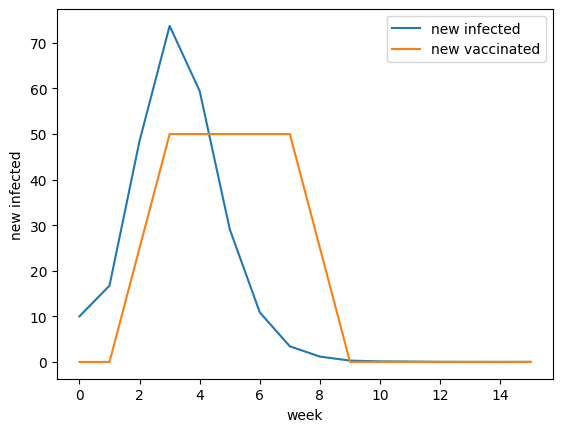

In [21]:
#plot the graph of newly infected in each week

time = np.arange(n_steps)

avg_newinfect = np.mean(newly_infected,axis = 0)
avg_newvaccinated = np.mean(newly_vaccinated,axis = 0)
print(np.round(avg_newinfect))
print(np.round(avg_newvaccinated))


fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'new infected')
plt.plot(time ,avg_newvaccinated, label = 'new vaccinated')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')

# plt.savefig('plot3new_infected')

Text(0, 0.5, 'n_agents')

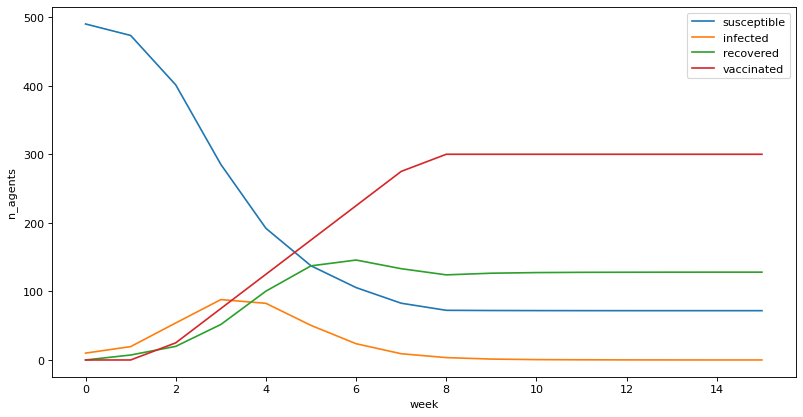

In [22]:
#plot graph of total susceptible, infected, recovered and vaccinated for each week
time = np.arange(n_steps)
avg_sus = np.mean(tot_susceptible,axis = 0)
avg_inf = np.mean(tot_infected,axis = 0)
avg_rec = np.mean(tot_recovered,axis = 0)
avg_vac = np.mean(tot_vaccinated,axis = 0)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')
plt.plot(time ,avg_vac, label = 'vaccinated')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')

# plt.savefig('plot3stats')

### Exercise 4

In [3]:
def H1N1simulationwithvaccine(simulation, n_steps, n_agents, k, beta, rho, vaccine):

    # define the vaccine
    vaccine = np.array(vaccine)
    # state saves the state of the agents for each week in each simulation
    states = np.zeros((simulation,n_steps,n_agents), dtype=np.int64)
    
    #stats
    newly_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    newly_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_susceptible = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_recovered = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)

    for sim in range(simulation):
        # for each simulation, we create a new graph
        G = randomgraph(k, n_nodes)
        W = nx.adjacency_matrix(G)
        W = sp.sparse.lil_matrix(W)
        
        # initialize the infected individual -> in this case it is only 1 
        x0 = np.zeros(n_agents, dtype=int)
        infect = np.random.choice(n_agents ,1 , replace=False)
        x0[infect]=1
        newly_infected[sim][0] = len(infect)
        
        # initialize vaccinated people
        vaccine_size = round(vaccine[0]*n_agents/100)
        # select all those who are not vaccinated, and random choose them according to the size
        node_notvaccinated = np.where(states[sim][0] != 4)
        new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False)
        # update their state 
        x0[new_vaccinated] = 4
        
        # stats
        newly_vaccinated[sim][0] = len(new_vaccinated)
        
        # define initial state id (time 0)
        states[sim][0] = x0

        # stats
        tot_susceptible[sim][0] = np.count_nonzero(states[sim][0] == 0)
        tot_infected[sim][0] = np.count_nonzero(states[sim][0] == 1)
        tot_recovered[sim][0] = np.count_nonzero(states[sim][0] == 2)
        tot_vaccinated[sim][0] = np.count_nonzero(states[sim][0] == 4)

        # for each step of the simulation
        for i in range(1,n_steps):
            
            # consider the current configuration 
            x = np.array(states[sim][i-1])
            
            # vaccination of the population
            vaccine_size = round((vaccine[i]-vaccine[i-1])*n_agents/100)
            # select those who are not vaccinated -> random choose a subset of them to be vaccinated 
            node_notvaccinated = np.where(states[sim][i-1] != 4)
            new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False)    
            # update the state
            x[new_vaccinated] = 4
            # update stats
            newly_vaccinated[sim][i] = len(new_vaccinated)

            # construct y as the next possible configuration based on the previous state considering also the people
            # who took a vaccine that day 
            y = np.array(x)

            for agent in range(n_agents):  
                if x[agent] == 0: # the node is susceptible
                    infected_neighbor = 0

                    for neighbor in [n for n in G.neighbors(agent)]:
                        # if the other agent is infected, x[other_agent] = 1
                        if x[neighbor] == 1:
                            infected_neighbor += 1
                            
                    rate = 1 - pow((1 - beta),infected_neighbor)
                    prob = [rate, 1-rate] # we will associate the probs as follows : 
                                          # 1-rate = not infect, rate = infect 
                    infection = np.random.choice([True, False] ,1, p = prob)[0]
                    if infection == True:
                        y[agent] = 1 # the agent become infected in the next config
                        newly_infected[sim][i] += 1

                if x[agent] == 1: # the node is infected
                    rate = rho
                    prob = [rate, 1-rate] 
                    recover = np.random.choice([True,False], 1, p = prob)[0]
                    if recover == True:
                        y[agent] = 2 # the agent become recovered in the next config


            # update the state
            states[sim][i] = y
            
            # update stats
            tot_susceptible[sim][i] = np.count_nonzero(states[sim][i] == 0)
            tot_infected[sim][i] = np.count_nonzero(states[sim][i] == 1)
            tot_recovered[sim][i] = np.count_nonzero(states[sim][i] == 2)
            tot_vaccinated[sim][i] = np.count_nonzero(states[sim][i] == 4)


    return newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated


In [338]:
# first run of the algorithm

simulation = 10
n_steps = 16
n_nodes = 934
k = 10
beta = 0.3
rho = 0.6
deltak = 1
deltab = 0.1
deltar = 0.1

repeat = True

# used to save the best parameters 
last_round = np.zeros(3)


epoch = 0
multiple = 1

# set vaccine
vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
while repeat:
    best_RMSE = np.inf # used for the 1st iteration
    
    # define the arrays where we want to iterate -> we run 27 parameters * 10 simulation = 270 simulations for each epoch
    karray = np.arange(k-deltak, k+2*deltak)
    barray = np.linspace(beta-deltab, beta+deltab, 3)
    rarray = np.linspace(rho-deltar, rho+deltar, 3)
    for ki in karray:
        for b in barray:
            for r in rarray:
                if k > 0 and b > 0 and r > 0 and b <=1 and r <=1: # only valid parameters
                    newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated = \
                        H1N1simulationwithvaccine(simulation, n_steps, n_nodes,ki, b, r,vaccine)
                    newinfect = np.mean(newly_infected,axis = 0)

                    MSE = np.square(np.subtract(infected,newinfect)).mean()
                    RMSE = math.sqrt(MSE)
                    if RMSE < best_RMSE:
                        best_RMSE = RMSE
                        config = np.array([ki,b,r])
                        avg_newinfect = np.mean(newly_infected,axis = 0)
                        avg_sus = np.mean(tot_susceptible,axis = 0)
                        avg_inf = np.mean(tot_infected,axis = 0)
                        avg_rec = np.mean(tot_recovered,axis = 0)
                        avg_vac = np.mean(tot_vaccinated,axis = 0)
    print(f'epoch : {epoch} with parameters {config} and RMSE : {best_RMSE}')
    epoch += 1
    if (last_round == config).all(): # if the parameter of the last round coincide with the new one 
        repeat = False # used to exit from the while loop
        print(f'simulation ended with epoches : {epoch} with RMSE : {best_RMSE}')
    else:
        # update last round 
        last_round = config
        k = int(config[0])
        beta = config[1]
        rho = config[2]
        if epoch == 10*multiple:# we could reduce by half the parameters after a certain amount of simulations 
                                # here is done after multiple of 10  
            deltab = deltab/2
            deltar = deltar/2
            multiple += 1
            

                    


print(f'the best parameters are {config} with RMSE : {best_RMSE}')     
          

epoch : 0 with parameters [10.   0.2  0.6] and RMSE : 5.117799820235255
epoch : 1 with parameters [9.  0.2 0.6] and RMSE : 5.2649192776337985
epoch : 2 with parameters [8.  0.2 0.6] and RMSE : 5.610648358255934
epoch : 3 with parameters [9.  0.2 0.5] and RMSE : 5.993225342000749
epoch : 4 with parameters [8.  0.2 0.4] and RMSE : 4.505690846030163
epoch : 5 with parameters [9.  0.2 0.3] and RMSE : 6.013058705850127
epoch : 6 with parameters [8.  0.2 0.4] and RMSE : 6.6259904919943855
epoch : 7 with parameters [7.  0.3 0.5] and RMSE : 5.863286194618168
epoch : 8 with parameters [6.  0.3 0.5] and RMSE : 5.225478446994113
epoch : 9 with parameters [5.  0.4 0.6] and RMSE : 4.73504223845997
epoch : 10 with parameters [5.  0.3 0.5] and RMSE : 6.481705022600149
epoch : 11 with parameters [5.  0.4 0.5] and RMSE : 6.7698319772354765
epoch : 12 with parameters [6.  0.3 0.4] and RMSE : 4.748223351949654
epoch : 13 with parameters [7.  0.2 0.4] and RMSE : 7.105279727076197
epoch : 14 with parameter

In [339]:
iteration = 3

[ 1.  1.  3.  9. 18. 32. 36. 29. 20. 13.  9.  6.  4.  2.  1.  1.]


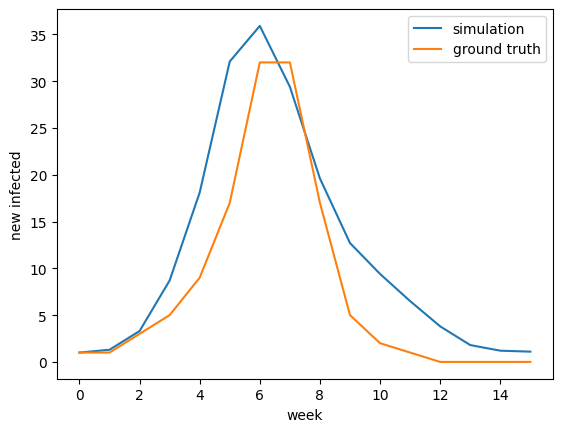

In [340]:
time = np.arange(n_steps)

print(np.round(avg_newinfect))

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'simulation')
plt.plot(time, infected, label = 'ground truth')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')


plt.savefig(f'plot4_10sim_infect{iteration}.png')

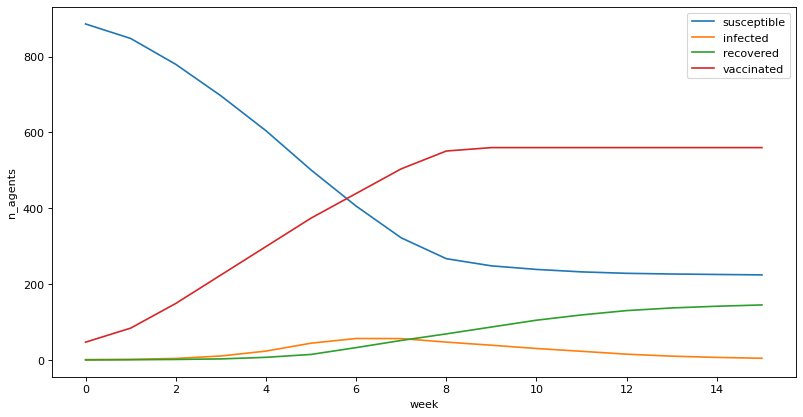

In [341]:
#plot graph of total susceptible, infected, recovered and vaccinated for each week
time = np.arange(n_steps)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')
plt.plot(time ,avg_vac, label = 'vaccinated')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')


plt.savefig(f'plot4_10sim_stats{iteration}.png')

In [342]:
# run a single simulation with the best parameters found by the algorithm 
simulation = 100
n_steps = 16
n_nodes = 934
RMSE = np.inf

vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]


newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, _ = \
    H1N1simulationwithvaccine(simulation, n_steps, n_nodes, k, beta, rho ,vaccine)
newinfect = np.mean(newly_infected,axis = 0)

MSE = np.square(np.subtract(infected,newinfect)).mean()
RMSE = math.sqrt(MSE)

print(f'RMSE = {np.round(RMSE,3)} with k = {np.around(k,2)}, b = {np.around(beta,2)} and rho = {np.around(rho,2)}')
 

RMSE = 5.568 with k = 7, b = 0.25 and rho = 0.45


[ 1.  1.  3.  8. 15. 22. 23. 18. 12. 10.  8.  6.  5.  4.  3.  2.]


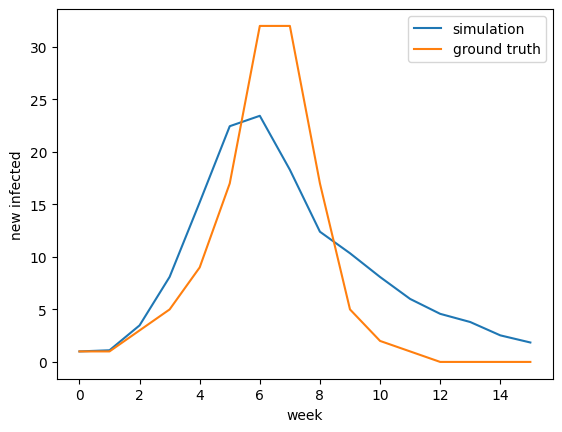

In [343]:
#plot the graph for newly infected in each week and compare it with the ground truth

time = np.arange(n_steps)

avg_newinfect = np.mean(newly_infected,axis = 0)
print(np.round(avg_newinfect))

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'simulation')
plt.plot(time, infected, label = 'ground truth')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')


plt.savefig(f'plot4_100sim_infect{iteration}.png')

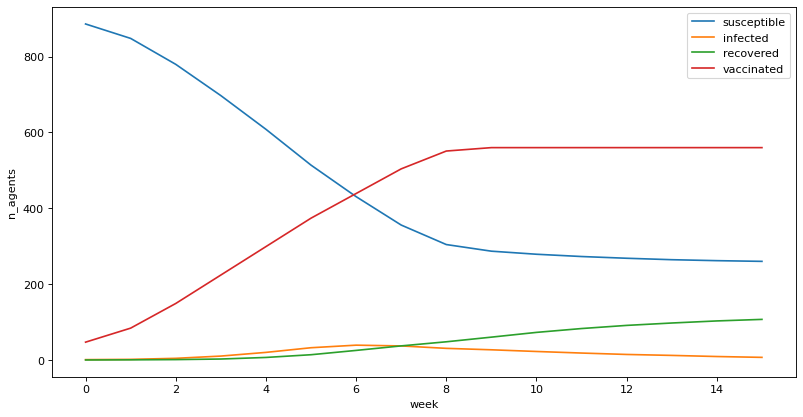

In [344]:
#plot graph of total susceptible, infected, recovered and vaccinated for each week
time = np.arange(n_steps)
avg_sus = np.mean(tot_susceptible,axis = 0)
avg_inf = np.mean(tot_infected,axis = 0)
avg_rec = np.mean(tot_recovered,axis = 0)
avg_vac = np.mean(tot_vaccinated,axis = 0)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')
plt.plot(time ,avg_vac, label = 'vaccinated')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')


plt.savefig(f'plot4_100sim_stats{iteration}.png')

### Exercise 1.5 (optional)

We will analyze the small world random graph

In [4]:
# Generate small world graph 

def smallworldrandomgraph(n_nodes, k, p):

    G = nx.cycle_graph(n_nodes)

    for n in range(n_nodes):
        for i in range(2,int(k/2)+1):
            G.add_edge(n,((n+i) % n_nodes))
            G.add_edge(n,((n-i) % n_nodes))

    for i in range(n_nodes):
        for j in range(n_nodes):
            if np.random.rand() < p:
                G.add_edge(i,j)
    return G

We use the same algorithm as before, just adjusting the function to generate the graph 

In [5]:
def H1N1simulationwithvaccinesmallworld(simulation, n_steps, n_agents, k, beta, rho, p, vaccine):

    # define the vaccine
    vaccine = np.array(vaccine)
    # state saves the state of the agents for each week in each simulation
    states = np.zeros((simulation,n_steps,n_agents), dtype=np.int64)
    
    #stats
    newly_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    newly_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_susceptible = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_infected = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_recovered = np.zeros((simulation,n_steps), dtype = np.int64)
    tot_vaccinated = np.zeros((simulation,n_steps), dtype = np.int64)

    for sim in range(simulation):
        # for each simulation, we create a new graph
        G = smallworldrandomgraph(n_nodes, k, p)
        W = nx.adjacency_matrix(G)
        W = sp.sparse.lil_matrix(W)
        
        # initialize the infected individual -> in this case it is only 1 
        x0 = np.zeros(n_agents, dtype=int)
        infect = np.random.choice(n_agents ,1 , replace=False)
        x0[infect]=1
        newly_infected[sim][0] = len(infect)
        
        # initialize vaccinated people
        vaccine_size = round(vaccine[0]*n_agents/100)
        # select all those who are not vaccinated, and random choose them according to the size
        node_notvaccinated = np.where(states[sim][0] != 4)
        new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False)
        # update their state 
        x0[new_vaccinated] = 4
        
        # stats
        newly_vaccinated[sim][0] = len(new_vaccinated)
        
        # define initial state id (time 0)
        states[sim][0] = x0

        # stats
        tot_susceptible[sim][0] = np.count_nonzero(states[sim][0] == 0)
        tot_infected[sim][0] = np.count_nonzero(states[sim][0] == 1)
        tot_recovered[sim][0] = np.count_nonzero(states[sim][0] == 2)
        tot_vaccinated[sim][0] = np.count_nonzero(states[sim][0] == 4)

        # for each step of the simulation
        for i in range(1,n_steps):
            
            # consider the current configuration 
            x = np.array(states[sim][i-1])
            
            # vaccination of the population
            vaccine_size = round((vaccine[i]-vaccine[i-1])*n_agents/100)
            # select those who are not vaccinated -> random choose a subset of them to be vaccinated 
            node_notvaccinated = np.where(states[sim][i-1] != 4)
            new_vaccinated = np.random.choice(node_notvaccinated[0], size=vaccine_size, replace=False)    
            # update the state
            x[new_vaccinated] = 4
            # update stats
            newly_vaccinated[sim][i] = len(new_vaccinated)

            # construct y as the next possible configuration based on the previous state considering also the people
            # who took a vaccine that day 
            y = np.array(x)

            for agent in range(n_agents):  
                if x[agent] == 0: # the node is susceptible
                    infected_neighbor = 0

                    for neighbor in [n for n in G.neighbors(agent)]:
                        # if the other agent is infected, x[other_agent] = 1
                        if x[neighbor] == 1:
                            infected_neighbor += 1
                            
                    rate = 1 - pow((1 - beta),infected_neighbor)
                    prob = [rate, 1-rate] # we will associate the probs as follows : 
                                          # 1-rate = not infect, rate = infect 
                    infection = np.random.choice([True, False] ,1, p = prob)[0]
                    if infection == True:
                        y[agent] = 1 # the agent become infected in the next config
                        newly_infected[sim][i] += 1

                if x[agent] == 1: # the node is infected
                    rate = rho
                    prob = [rate, 1-rate] 
                    recover = np.random.choice([True,False], 1, p = prob)[0]
                    if recover == True:
                        y[agent] = 2 # the agent become recovered in the next config


            # update the state
            states[sim][i] = y
            
            # update stats
            tot_susceptible[sim][i] = np.count_nonzero(states[sim][i] == 0)
            tot_infected[sim][i] = np.count_nonzero(states[sim][i] == 1)
            tot_recovered[sim][i] = np.count_nonzero(states[sim][i] == 2)
            tot_vaccinated[sim][i] = np.count_nonzero(states[sim][i] == 4)


    return newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated


In [373]:
# first run of the algorithm

simulation = 10
n_steps = 16
n_nodes = 934
k = 10
beta = 0.3
rho = 0.6
prob = 0.03
deltak = 2
deltab = 0.1
deltar = 0.05
deltap = 0.01

repeat = True
last_round = np.zeros(4)
# used to save the best result

epoch = 0
multiple = 1



vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]
while repeat:
    best_RMSE = np.inf
    
    # define the set of parameters -> here for each iteration we run 
    # 81 combination of parameters * 10simulation = 810 experiments -> it takes longer than Problem 1.4
    karray = np.arange(k-deltak, k+2*deltak, deltak)
    barray = np.linspace(beta-deltab, beta+deltab, 3)
    rarray = np.linspace(rho-deltar, rho+deltar, 3)
    parray = np.linspace(prob-deltap, prob+deltap, 3)
    
    
    for ki in karray:
        for b in barray:
            for r in rarray:
                for p in parray:
                    if ki > 0 and b > 0 and r > 0 and p > 0 and b <=1 and r <=1 and p<=1: # only valid parameters
                        newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated = \
                            H1N1simulationwithvaccinesmallworld(simulation, n_steps, n_nodes, ki, b, r, p, vaccine)
                        
                        # computation of RMSE
                        newinfect = np.mean(newly_infected,axis = 0)
                        MSE = np.square(np.subtract(infected,newinfect)).mean()
                        RMSE = math.sqrt(MSE)
                        
                        # check if it is better than the best_value  
                        if RMSE < best_RMSE: #update the stats 
                            best_RMSE = RMSE
                            config = np.array([ki, b, r, p])
                            avg_newinfect = np.mean(newly_infected,axis = 0)
                            avg_sus = np.mean(tot_susceptible,axis = 0)
                            avg_inf = np.mean(tot_infected,axis = 0)
                            avg_rec = np.mean(tot_recovered,axis = 0)
                            avg_vac = np.mean(tot_vaccinated,axis = 0)
    print(f'epoch : {epoch} with parameters {config} and RMSE : {best_RMSE}')
    
    if (last_round == config).all():
        repeat = False # flag used to exit from the while loop
        print(f'simulation ended with epoches : {epoch} with RMSE : {best_RMSE}')
    else:
        
        epoch += 1
        last_round = config
        k = int(config[0])
        beta = config[1]
        rho = config[2]
        prob = config[3]
        if epoch == 5*multiple: # for every multiple of 5 we reduce the deltas
            multiple += 1
            deltab = deltab/2
            deltar = deltar/2
            deltap = deltap/2
            

                    


print(f'the best parameters are {config} with RMSE : {best_RMSE}')     
          

epoch : 0 with parameters [8.   0.2  0.6  0.02] and RMSE : 79.96256155226644
epoch : 1 with parameters [6.   0.1  0.65 0.01] and RMSE : 6.803583614537269
epoch : 2 with parameters [6.   0.1  0.7  0.01] and RMSE : 6.738323233564861
epoch : 3 with parameters [8.   0.1  0.75 0.01] and RMSE : 5.847061227659585
epoch : 4 with parameters [1.e+01 1.e-01 8.e-01 1.e-02] and RMSE : 5.432195688669546
epoch : 5 with parameters [1.0e+01 1.5e-01 8.0e-01 5.0e-03] and RMSE : 5.7614559791774855
epoch : 6 with parameters [8.   0.1  0.8  0.01] and RMSE : 5.792290134307845
epoch : 7 with parameters [1.00e+01 1.50e-01 8.25e-01 5.00e-03] and RMSE : 4.642399702739953
epoch : 8 with parameters [1.0e+01 1.5e-01 8.5e-01 5.0e-03] and RMSE : 6.575142584005309
epoch : 9 with parameters [1.0e+01 1.5e-01 8.5e-01 5.0e-03] and RMSE : 5.57953851138246
simulation ended with epoches : 9 with RMSE : 5.57953851138246
the best parameters are [1.0e+01 1.5e-01 8.5e-01 5.0e-03] with RMSE : 5.57953851138246


In [374]:
iteration = 0

[ 1.  2.  5.  9. 15. 22. 25. 22. 17. 14. 10.  7.  7.  5.  3.  2.]


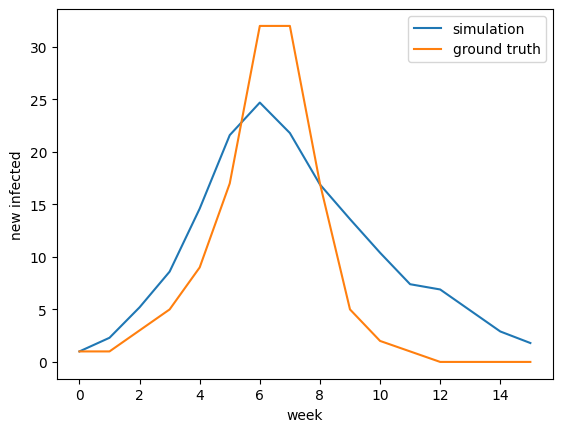

In [375]:
time = np.arange(n_steps)

print(np.round(avg_newinfect))

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'simulation')
plt.plot(time, infected, label = 'ground truth')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')


plt.savefig(f'plot5_10sim_infect{iteration}.png')

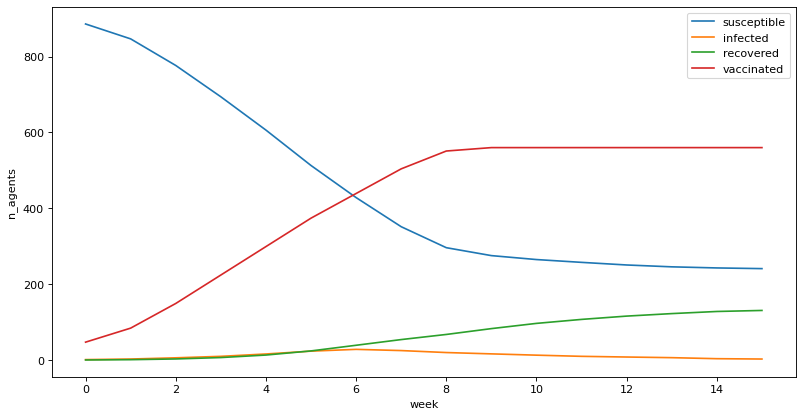

In [376]:
#plot graph of total susceptible, infected, recovered and vaccinated for each week
time = np.arange(n_steps)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')
plt.plot(time ,avg_vac, label = 'vaccinated')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')


plt.savefig(f'plot5_10sim_stats{iteration}.png')

In [397]:
# run the experiment with 100 simulation for a more stable result 
simulation = 100
n_steps = 16
n_nodes = 934
RMSE = np.inf

vaccine = [5, 9, 16, 24, 32, 40, 47, 54, 59, 60, 60, 60, 60, 60, 60, 60]
infected = [1, 1, 3, 5, 9, 17, 32, 32, 17, 5, 2, 1, 0, 0, 0, 0]


newly_infected, tot_susceptible, tot_infected, tot_recovered, tot_vaccinated, newly_vaccinated = \
                            H1N1simulationwithvaccinesmallworld(simulation, n_steps, n_nodes, k, beta, rho, prob, vaccine)
newinfect = np.mean(newly_infected,axis = 0)

MSE = np.square(np.subtract(infected,newinfect)).mean()
RMSE = math.sqrt(MSE)

print(f'RMSE = {np.round(RMSE,3)} with k = {np.around(k,2)}, b = {np.around(beta,2)}, rho = {np.around(rho,2)} and p = {np.around(prob,4)}')
 

RMSE = 5.744 with k = 10, b = 0.15, rho = 0.85 and p = 0.005


[ 1.  3.  5. 10. 17. 23. 26. 24. 18. 14. 11.  8.  6.  5.  3.  3.]


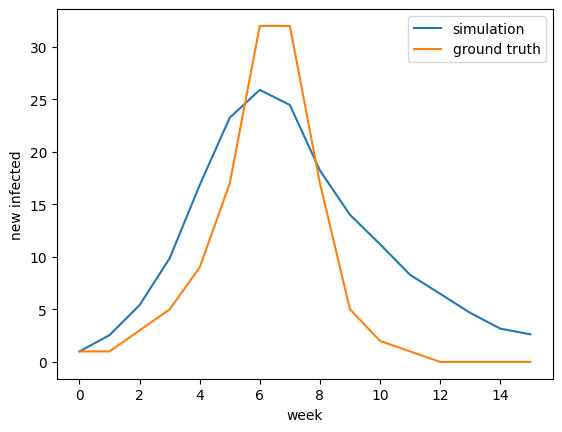

In [398]:
#plot the graph for newly infected in each week and compare it with the ground truth

time = np.arange(n_steps)

avg_newinfect = np.mean(newly_infected,axis = 0)
print(np.round(avg_newinfect))

fig1 = plt.figure() 
plt.plot(time ,avg_newinfect, label = 'simulation')
plt.plot(time, infected, label = 'ground truth')
plt.legend()
plt.xlabel('week')
plt.ylabel('new infected')


plt.savefig(f'plot5_100sim_infect{iteration}.png')

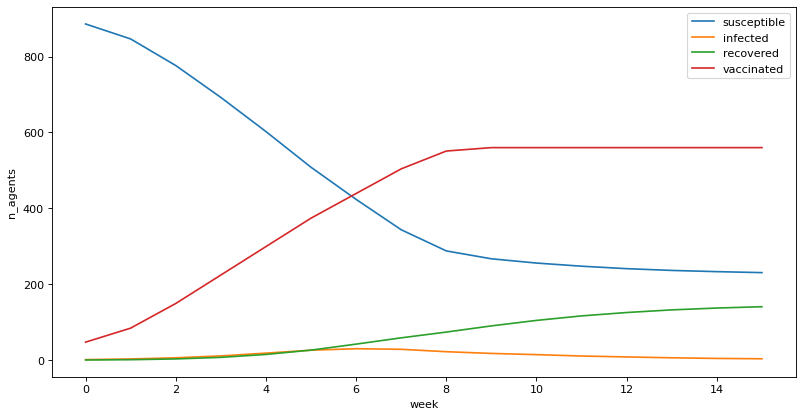

In [399]:
#plot graph of total susceptible, infected, recovered and vaccinated for each week
time = np.arange(n_steps)
avg_sus = np.mean(tot_susceptible,axis = 0)
avg_inf = np.mean(tot_infected,axis = 0)
avg_rec = np.mean(tot_recovered,axis = 0)
avg_vac = np.mean(tot_vaccinated,axis = 0)

fig2 = plt.figure(figsize=(12, 6), dpi=80) 
plt.plot(time ,avg_sus, label = 'susceptible')
plt.plot(time ,avg_inf, label = 'infected')
plt.plot(time ,avg_rec, label = 'recovered')
plt.plot(time ,avg_vac, label = 'vaccinated')

plt.legend()
plt.xlabel('week')
plt.ylabel('n_agents')


plt.savefig(f'plot5_100sim_stats{iteration}.png')

# Exercise 2

### Exercise 2.1

In this part, we will study graph coloring as an application of distributed learning in potential
games. The aim of graph coloring is to assign a color to each node in a given undirected
graph, such that none of the neighbors of a node have the same color as that node.

In this example, study a line graph with 10 nodes. Denote the i-th node state by $X_i(t)$ and the set of possible states by $C = {red, green}$. At initialization, each node is red, i.e, $X_i(t)$ = red for all $i = 1, . . . , 10$. Every discrete time instance t, one node $I(t)$, chosen uniformly at random, wakes up and updates its color.
The new color (resulting from a node’s update), is chosen from a probability distribution given by
$$
    P(X_i(t+1) = a | X(t), I(t) = i) = \frac{e^{-\eta(t)\sum_{j}{W_{ij}c(a,X_j(t))}}}{\sum_{s \in C}e^{-\eta(t)\sum_{j}{W_{ij}c(a,X_j(t))}}}
$$

Where the cost is given by 
\begin{equation}
    c(s,X_j(t))=
    \begin{cases}
      1 & \text{if}\ X_j(t) = s \\
      0 & \text{otherwise}
    \end{cases}
  \end{equation}
  
In the above expression, $\eta(t)$ is the inverse of the noise. To decide upon a good choice of $\eta(t)$, some heuristics are required, but it is preferable to have it increasing in time so that the noise is decreasing. For this exercise you can start with
$$
    \eta(t) = \frac{t}{100}
$$
To study how close to a solution the learning algorithm is, we consider the potential function, which is given by
$$
    U(t) = \frac{1}{2}\sum_{i,j \in \mathbf{V}}{W_{ij}c(X_i(t),X_j(t))}
$$
where $\mathbf{V}$ is the set of nodes. If the potential is zero, there are no conflicting nodes and a solution is found.


In [52]:
# create a line graph with 10 edges
n_nodes = 10
n_states = 2
colors = ['red', 'green']

# concatenate the edges because 
edges = list()
for i in range(1,n_nodes):
    edges.append((i-1, i))

G = nx.Graph()
G.add_edges_from(edges)

W = nx.adjacency_matrix(G)
W = W.toarray()


# suppose red = 0, yellow = 1
# initial configuration = all red -> all zeros 
config = np.zeros(n_nodes, dtype = int)
states = np.array([0,1])
# starting time 
time = 0
potential_value = list()

while True:
    # compute the potential at each start
    U = 0
    for node in range(n_nodes):
        neighbors = list(G.neighbors(node))
        for neighbor in neighbors:
            # we are checking if there are 2 adjacent node with same state. 
            # If yes, we add the contibution to the potential function
            if config[node] == config[neighbor]:
                U += W[node][neighbor]
    potential_value.append(U/2)
    # if the potential is zero, we quit from the cycle
    if U == 0:
        break
        
        
    # choose one node uniformly and wake it up
    node = np.random.randint(0, n_nodes)
    # in order to apply the prob formula, we need some extra elements:
    # - neighbors weight -> actually it is one so there's not big difference
    # - cost associated to each neighbor
    neighbors = list(G.neighbors(node))
    
    # initializing the probability array -> we will need to normalize it 
    probs = np.zeros(n_states)
    
    for state in states:
        nominator = 0
        for neighbor in neighbors:
            if state == config[neighbor]:      # if they have same state, increment the cost
                nominator += W[node, neighbor] # it is equivalent to increment by 1
                
        probs[state] = np.exp(-time*nominator/100) # formula used to compute the nominator of the NBR prob       

    # normalize the probabilities
    probs = probs/sum(probs)

    # random choose the new_state according to the probabilities
    new_state = np.random.choice(states, p = probs)

    # update the states vector and increment the time 
    config[node] = new_state
    time += 1
    
    # compute the potential function -> when potential function = 0 we are done 
    

# print the final configuration
print(f'time to reach final configuration : {time} with configuration : \n{config}')






time to reach final configuration : 156 with configuration : 
[0 1 0 1 0 1 0 1 0 1]


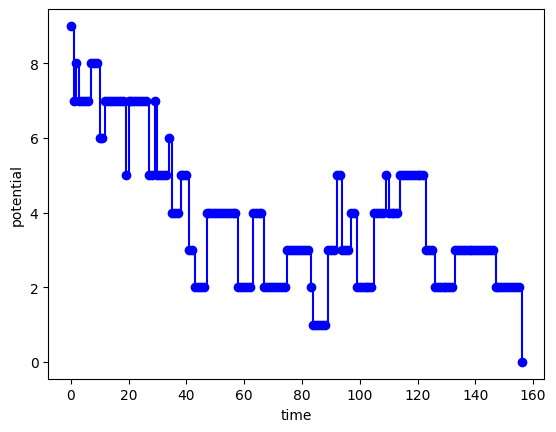

In [53]:
plt.step(np.arange(len(potential_value)), potential_value, 'bo-', where="post")
plt.ylabel('potential')
plt.xlabel('time')
plt.savefig('Ex2plot1.png')

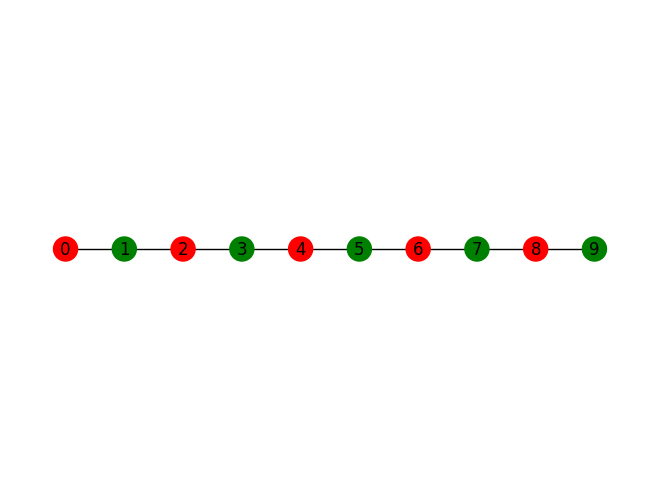

In [55]:
color_config = [colors[i] for i in config]
pos = {}
positions = {0:[0,0],1:[1,0],2:[1,1],3:[0,1]}
for i in range(len(config)):
    pos[i] = [i-5,0]
nx.draw(G, pos = pos,node_color = color_config ,with_labels = True)
plt.savefig('ex2line.png')

### Exercise 2.2

The adjacency matrix of a network of 100 routers is given in $wifi.mat$ and the routers’ coordinates are given in $coord.mat$. Here, a link between two nodes means that the two routers are able to interfere with each other. The set of possible
states is $$
C = \{1 : red, 2 : green, 3 : blue, 4 : yellow, 5 : magenta, 6 : cyan, 7 : white, 8 : black\}
$$
where colors represent frequency bands, and the cost function is
\begin{equation}
    c(s,X_j(t))=
    \begin{cases}
      2 & \text{if}\ X_j(t) = s \\
      1 & \text{if}\ |X_j(t) - s| = 1 \\
      0 & \text{otherwise}
    \end{cases}
  \end{equation}
The cost function $c(s, X_j(t))$ symbolizes that routers that are close by should not use
channels with the same frequency band or a frequency band right next to each other.


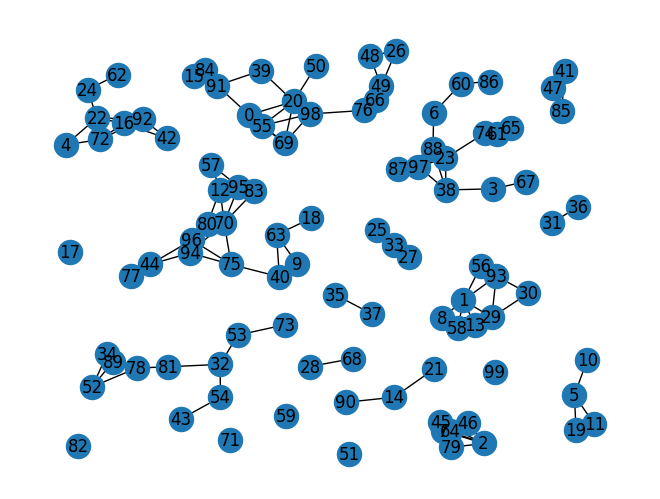

In [7]:
# load matrix W from the given wifi file
W = np.loadtxt('wifi.mat')
pos = np.loadtxt('coords.mat')
pos = pos

# create the new graph to inspect
G2 = nx.from_numpy_matrix(W)

nx.draw(G2, pos= pos, with_labels = True)
plt.savefig('Ex2wifigraph')

In [57]:
# check if graph connected (although it could be seen from the graph that it is not)
nx.algorithms.is_connected(G2)

False

Uniform configuration

color red done in 568 time
color green done in 391 time
color blue done in 761 time
color yellow done in 324 time
color magenta done in 682 time
color cyan done in 491 time
color white done in 546 time
color black done in 476 time


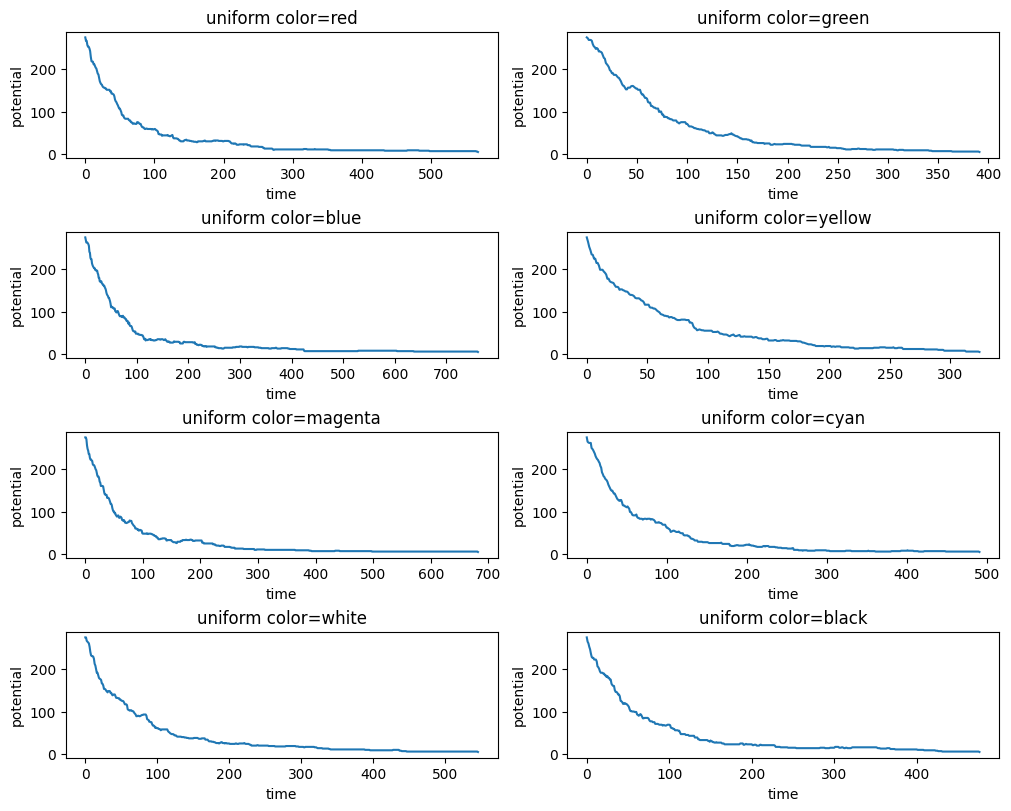

In [108]:
n_nodes = len(G2.nodes)
# C = {1 : red, 2 : green, 3 : blue, 4 : yellow, 5 : magenta, 6 : cyan, 7 : white, 8 : black}
# To simplify the code, we will start encoding the colors from zero: meaning that 
# C = {0 : red, 1 : green, 2 : blue, 3 : yellow, 4 : magenta, 5 : cyan, 6 : white, 7 : black}
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'black']
n_states = 8
states = np.arange(n_states)
potentials = list()


for color in states:
    # initial configuration = all red -> all zeros 
    config = color*np.ones(n_nodes)
    
    # starting time 
    time = 0
    potential_value = list()

    while True:
        # compute the potential function -> when potential function lower than a threshold we are done 
        U = 0
        for node in range(n_nodes):
            neighbors = list(G2.neighbors(node))
            for neighbor in neighbors:
                # we are checking if there are 2 adjacent node with same state. 
                # If yes, we add the contibution to the potential function according to the cost function
                if config[node] == config[neighbor]:
                    U += W[node][neighbor]*2
                elif abs(config[node]-config[neighbor]) == 1: # if the states differ from one distance in the codification
                    U += W[node,neighbor]
        potential_value.append(U/2)
        # if the potential is near zero, we quit from the cycle
        if U/2 < 6:
            potentials.append(potential_value)
            print(f'color {colors[color]} done in {time} time')
            break
        
        
        # choose one node uniformly and wake it up
        node = np.random.randint(0, n_nodes)
        
        # in order to apply the prob formula, we need some extra elements:
        # - neighbors, in order to retrieve the cost associated to each neighbor 
        neighbors = list(G2.neighbors(node))

        # initialize the prob array -> useful later for normalization 
        probs = np.zeros(n_states)

        for state in states:
            nominator = 0
            for neighbor in neighbors:
                if state == config[neighbor]:         # if they have same state, increment the cost by 2
                    nominator += 2*W[node, neighbor]
                elif abs(state-config[neighbor]) == 1: # if the states differ from one distance in the codification
                    nominator += W[node,neighbor]
                    
            probs[state] = np.exp(-time*nominator/100) # nominator of the prob according to NBR prob

        # normalize the probabilities
        probs = probs/sum(probs)

        # random choose the new_state according to the probabilities
        new_state = np.random.choice(states, p = probs)

        # update the states vector and increment the time 
        config[node] = new_state
        time += 1

        



    
fig, ax = plt.subplots(int(n_states/2) ,2, figsize = (10,8), constrained_layout=True)
for ax, color in zip(ax.reshape(-1), range(n_states)):
    ax.set_title(f'uniform color={colors[color]}')
    ax.plot(np.arange(len(potentials[color])), potentials[color])
    ax.set_ylabel('potential')
    ax.set_xlabel('time')
#ax[color].step(np.arange(len(potential_value)), potential_value, 'bo-', where="post");
plt.savefig('Exercise2_2uniform_color.png')

Random configuration

starting config : [5 2 7 4 7 0 2 4 7 3 2 7 4 6 7 7 4 6 4 4 6 4 3 0 0 0 4 5 1 1 2 3 6 6 4 0 2
 4 5 3 4 2 7 1 0 4 4 7 1 7 4 3 7 0 0 5 0 6 3 0 4 4 5 3 0 0 1 7 3 0 4 6 6 6
 6 4 3 7 0 2 0 4 6 0 4 7 0 1 2 3 6 1 3 2 6 0 7 3 6 6]
time to reach final configuration : 658 with configuration : 
[7 0 2 0 1 1 5 5 6 5 5 3 2 4 3 7 3 6 7 6 3 5 7 0 3 2 5 0 6 2 4 1 5 6 3 2 3
 0 4 0 7 3 7 7 0 7 4 0 3 0 6 5 5 7 0 0 3 7 7 6 3 1 7 4 0 3 4 5 2 5 5 2 5 0
 7 0 2 2 7 6 0 1 1 7 2 5 1 4 2 0 6 4 1 7 2 0 7 7 7 3]


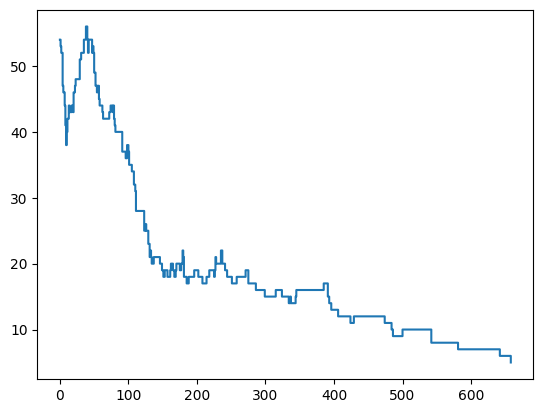

In [195]:
n_nodes = len(G2.nodes)
# C = {1 : red, 2 : green, 3 : blue, 4 : yellow, 5 : magenta, 6 : cyan, 7 : white, 8 : black}
# To simplify the code, we will start encoding the colors from zero: meaning that 
# C = {0 : red, 1 : green, 2 : blue, 3 : yellow, 4 : magenta, 5 : cyan, 6 : white, 7 : black}
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'black']
n_states = 8
states = np.arange(n_states)

# initial configuration = random choice 
config = np.random.choice(n_states, n_nodes)
print(f'starting config : {config}')

# starting time 
time = 0
potential_value = list()

while True:
    # compute the potential function -> when potential function lower than a threshold we are done 
    U = 0
    for node in range(n_nodes):
        neighbors = list(G2.neighbors(node))
        for neighbor in neighbors:
            # we are checking if there are 2 adjacent node with same state. 
            # If yes, we add the contibution to the potential function according to the cost function
            if config[node] == config[neighbor]:
                U += W[node][neighbor]*2
            elif abs(config[node]-config[neighbor]) == 1: # if the states differ from one distance in the codification
                U += W[node,neighbor]
    potential_value.append(U/2)
    # if the potential is zero, we quit from the cycle
    if U/2 < 6:
        break
    
    # choose one node uniformly and wake it up
    node = np.random.randint(0, n_nodes)
    
    # in order to apply the prob formula, we need some extra elements: 
    # - neighbors -> in order to cost associated to each neighbor
    neighbors = list(G2.neighbors(node))

    probs = np.zeros(n_states)

    for state in states:
        nominator = 0
        for neighbor in neighbors:
            if state == config[neighbor]:          # if they have same state, increment the cost by 2
                nominator += 2*W[node, neighbor]
            elif abs(state-config[neighbor]) == 1: # if the states differ only one distance in terms of encoding
                nominator += W[node,neighbor]
                
        probs[state] = np.exp(-time*nominator/100) # numerator of the NBR probability

    # normalize the probabilities
    probs = probs/sum(probs)

    # random choose the new_state according to the probabilities
    new_state = np.random.choice(states, p = probs)

    # update the states vector and increment the time 
    config[node] = new_state
    time += 1

    
    

# print the final configuration
print(f'time to reach final configuration : {time} with configuration : \n{config}')
plt.step(np.arange(len(potential_value)), potential_value, where="post")
# plt.savefig('Ex2randomconfig.png')

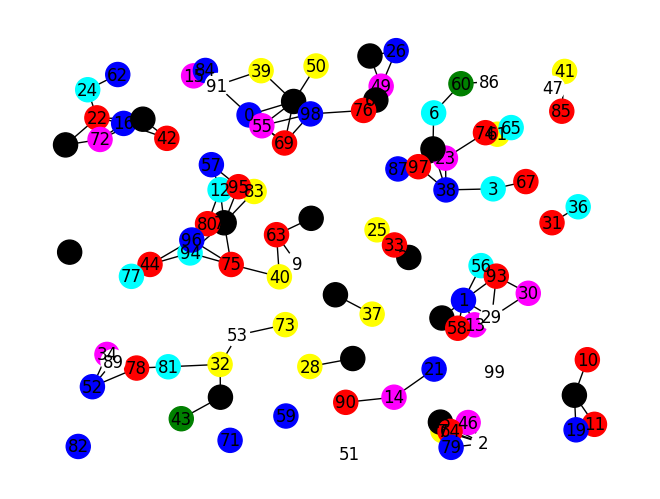

In [79]:
color_config = [colors[i] for i in config]
nx.draw(G2, pos= pos, node_color = color_config ,with_labels = True)
# plt.savefig('ex2color')

### Exercise 2.3

We will run with 3 different values for \eta (t)
- \eta(t) = 2 (constant)
- \eta(t) = $\frac{t^2}{100}$
- \eta(t) = $log(\frac{t}{100})$

change the prob function and the threshold value according to each set

uniform configuration

color red done in 2109 time
color green done in 2192 time
color blue done in 1879 time
color yellow done in 1560 time
color magenta done in 2230 time
color cyan done in 1780 time
color white done in 2380 time
color black done in 1673 time


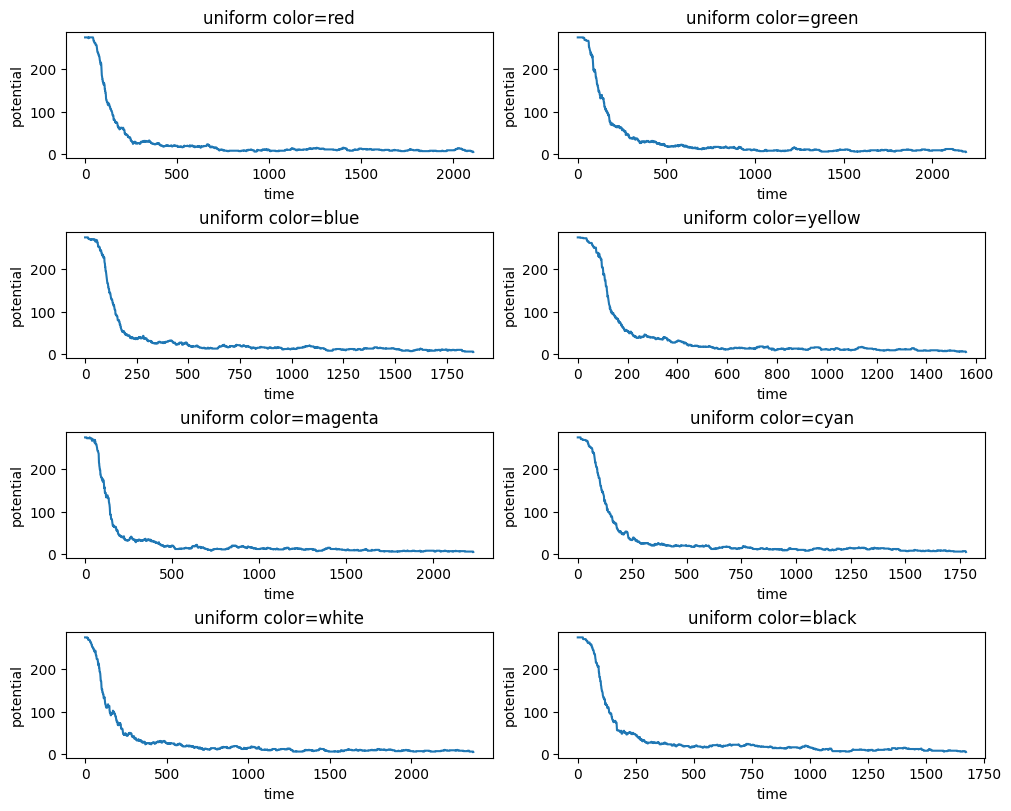

In [8]:
n_nodes = len(G2.nodes)
threshold = 6
# C = {1 : red, 2 : green, 3 : blue, 4 : yellow, 5 : magenta, 6 : cyan, 7 : white, 8 : black}
# To simplify the code, we will start encoding the colors from zero: meaning that 
# C = {0 : red, 1 : green, 2 : blue, 3 : yellow, 4 : magenta, 5 : cyan, 6 : white, 7 : black}
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'black']
n_states = 8
states = np.arange(n_states)
potentials = list()

for color in states:
    # initial configuration = all red -> all zeros 
    config = color*np.ones(n_nodes)
    
    # starting time 
    time = 1
    potential_value = list()

    while True:
        # compute the potential function -> when potential function lower than a threshold we are done 
        U = 0
        for node in range(n_nodes):
            neighbors = list(G2.neighbors(node))
            for neighbor in neighbors:
                # we are checking if there are 2 adjacent node with same state. 
                # If yes, we add the contibution to the potential function according to the cost function
                if config[node] == config[neighbor]:
                    U += W[node][neighbor]*2
                elif abs(config[node]-config[neighbor]) == 1: # if the states differ from one distance in the codification
                    U += W[node,neighbor]
        potential_value.append(U/2)
        # if the potential is near zero, we quit from the cycle
        if U/2 < threshold:
            potentials.append(potential_value)
            print(f'color {colors[color]} done in {time} time')
            break
        
        
        # choose one node uniformly and wake it up
        node = np.random.randint(0, n_nodes)
        
        # in order to apply the prob formula, we need some extra elements:
        # - neighbors, in order to retrieve the cost associated to each neighbor 
        neighbors = list(G2.neighbors(node))

        # initialize the prob array -> useful later for normalization 
        probs = np.zeros(n_states)

        for state in states:
            nominator = 0
            for neighbor in neighbors:
                if state == config[neighbor]:         # if they have same state, increment the cost by 2
                    nominator += 2*W[node, neighbor]
                elif abs(state-config[neighbor]) == 1: # if the states differ from one distance in the codification
                    nominator += W[node,neighbor]
            
            probs[state] = np.exp(-(np.log(time/100))*nominator) # nominator of the prob according to NBR prob
        
        # normalize the probabilities
        probs = probs/sum(probs)

        # random choose the new_state according to the probabilities
        new_state = np.random.choice(states, p = probs)

        # update the states vector and increment the time 
        config[node] = new_state
        time += 1

    
fig, ax = plt.subplots(int(n_states/2) ,2, figsize = (10,8), constrained_layout=True)
for ax, color in zip(ax.reshape(-1), range(n_states)):
    ax.set_title(f'uniform color={colors[color]}')
    ax.plot(np.arange(len(potentials[color])), potentials[color])
    ax.set_ylabel('potential')
    ax.set_xlabel('time')
#ax[color].step(np.arange(len(potential_value)), potential_value, 'bo-', where="post");
plt.savefig('Exercise2_4uniform_color.png')

random starting configuration

starting config : [6 6 7 2 3 1 2 0 1 0 2 1 4 1 2 7 7 2 7 2 3 2 1 3 7 1 6 0 2 3 4 5 1 0 0 5 0
 3 5 0 4 0 3 0 6 1 6 7 0 5 2 3 0 5 5 1 0 7 4 4 1 0 6 6 4 4 5 0 6 2 4 3 6 5
 0 7 4 7 0 6 6 5 5 6 6 1 3 3 1 4 7 4 5 5 3 5 7 5 7 0]
time to reach final configuration : 2250 with configuration : 
[0 2 6 3 0 2 6 0 0 1 0 5 7 5 6 6 6 3 0 0 2 2 4 4 6 1 0 3 6 7 2 2 2 6 0 0 6
 3 0 6 5 0 4 3 1 2 4 7 3 7 7 6 4 6 6 7 0 2 4 6 3 1 0 7 2 3 0 1 4 5 0 4 2 4
 7 3 5 6 2 7 3 4 3 2 2 4 6 0 2 6 4 4 0 5 7 5 5 5 0 1]


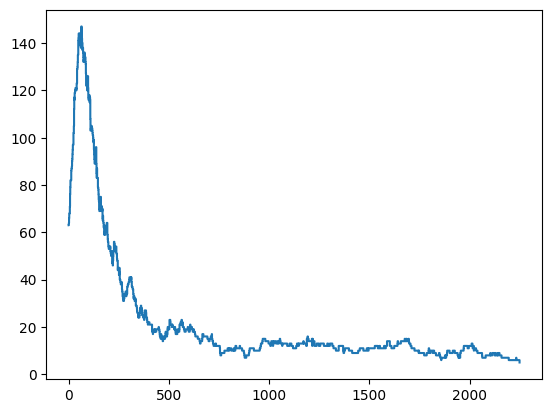

In [304]:
n_nodes = len(G2.nodes)
threshold = 6
# C = {1 : red, 2 : green, 3 : blue, 4 : yellow, 5 : magenta, 6 : cyan, 7 : white, 8 : black}
# To simplify the code, we will start encoding the colors from zero: meaning that 
# C = {0 : red, 1 : green, 2 : blue, 3 : yellow, 4 : magenta, 5 : cyan, 6 : white, 7 : black}
colors = ['red', 'green', 'blue', 'yellow', 'magenta', 'cyan', 'white', 'black']
n_states = 8
states = np.arange(n_states)

# initial configuration = random choice 
config = np.random.choice(n_states, n_nodes)
print(f'starting config : {config}')

# starting time 
time = 1
potential_value = list()

while True:
    # compute the potential function -> when potential function lower than a threshold we are done 
    U = 0
    for node in range(n_nodes):
        neighbors = list(G2.neighbors(node))
        for neighbor in neighbors:
            # we are checking if there are 2 adjacent node with same state. 
            # If yes, we add the contibution to the potential function according to the cost function
            if config[node] == config[neighbor]:
                U += W[node][neighbor]*2
            elif abs(config[node]-config[neighbor]) == 1: # if the states differ from one distance in the codification
                U += W[node,neighbor]
    potential_value.append(U/2)
    # if the potential is zero, we quit from the cycle
    if U/2 < threshold:
        break
    
    # choose one node uniformly and wake it up
    node = np.random.randint(0, n_nodes)
    
    # in order to apply the prob formula, we need some extra elements: 
    # - neighbors -> in order to cost associated to each neighbor
    neighbors = list(G2.neighbors(node))

    probs = np.zeros(n_states)

    for state in states:
        nominator = 0
        for neighbor in neighbors:
            if state == config[neighbor]:          # if they have same state, increment the cost by 2
                nominator += 2*W[node, neighbor]
            elif abs(state-config[neighbor]) == 1: # if the states differ only one distance in terms of encoding
                nominator += W[node,neighbor]
                
        probs[state] = np.exp(-np.log(time/100)*nominator) # numerator of the NBR probability

    # normalize the probabilities
    probs = probs/sum(probs)

    # random choose the new_state according to the probabilities
    new_state = np.random.choice(states, p = probs)

    # update the states vector and increment the time 
    config[node] = new_state
    time += 1

    
    

# print the final configuration
print(f'time to reach final configuration : {time} with configuration : \n{config}')
plt.step(np.arange(len(potential_value)), potential_value, where="post")
plt.savefig('Exercise2_4random_color.png')